## Funnel Analysis

### Goal

The goal is to perform funnel analysis for an e-commerce website.

Typically, websites have a clear path to conversion: for instance, you land on the home page, then you search, select a product and buy it. At each of these steps, some users will drop off and leave the site. The sequence of pages that leads to conversion is called ‘funnel’ .

Data Science can have a tremendous impact on funnel optimization. 
Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights on user behavior and on ways to improve the user experience as well as it often allows to discover bugs.


### Challenge Description


You are looking at data from an e-commerce website. The site is very simple and has just 4 pages:


1. The first page is the home page. When you come to the site for the first time, you can only land on the home page as a first page.

2. From the home page, the user can perform a search and land on the search page.

3. From the search page, if the user clicks on a product, she will get to the payment page, where she is asked to provide payment information in order to buy that product.

4. If she does decide to buy, she ends up on the confirmation page


The company CEO isn’t very happy with the company sales and, especially, sales coming from new users. Therefore, she asked you to investigate whether there is something wrong in the conversion funnel or, in general, if you can create hypotheses on how conversion rate could be improved.

Specifically, she is interested in :



A full picture of funnel conversion rate for both desktop and mobile


Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.




#### Data
**user_table** - info about the user

Columns:

user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables        
date : the date when the user firstly landed on the site       
device : user device. Can be mobile or desktop     
sex : male/female


**home_page_table** - Users who landed on the home page

Columns:

user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables    
page : it is always home_page.


**search_page_table** - Users who landed on the search_page

Columns:

user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables     
page : it is always search_page


**payment_page_table** - Users who landed on the payment_page

Columns:

user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables    
page : it is always payment_page


**payment_confirmation_table** - Users who landed on the payment_confirmation_table. That is, these are the users who bought the product.

Columns:

user_id : the Id of the user. It is unique by user and can be joined to user id in all other tables   
page : it is always payment_confirmation_page


In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('precision',2)
%matplotlib inline

In [2]:
user_df = pd.read_csv("Funnel_Analysis/user_table.csv")
home_df = pd.read_csv("Funnel_Analysis/home_page_table.csv")
search_df = pd.read_csv("Funnel_Analysis/search_page_table.csv")
pay_df = pd.read_csv("Funnel_Analysis/payment_page_table.csv")
confirm_df = pd.read_csv("Funnel_Analysis/payment_confirmation_table.csv")

In [35]:
user_df.name = "user_df"
home_df.name = "home_df"
search_df.name = "search_df"
pay_df.name = "pay_df"
confirm_df.name = "confirm_df"

In [30]:
home_df.name = "home_page"

In [32]:
home_df.name

'home_page'

In [22]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [23]:
get_df_name(home_df)

'home_df'

In [36]:
#check uniqueness of user_id in each table
datasets = list([home_df,search_df,pay_df,confirm_df])
for df in datasets:
    print("{} total length: {}, number of unique user_id: {}".format(df.name,len(df),df['user_id'].nunique()))

home_df total length: 90400, number of unique user_id: 90400
search_df total length: 45200, number of unique user_id: 45200
pay_df total length: 6030, number of unique user_id: 6030
confirm_df total length: 452, number of unique user_id: 452


In [54]:
merge_df = pd.merge(user_df,home_df, on=['user_id'],how='left')
merge_df = pd.merge(merge_df,search_df, on=['user_id'],how='left',suffixes=('_home', '_search'))
merge_df = pd.merge(merge_df,pay_df, on=['user_id'],how='left')
merge_df = pd.merge(merge_df,confirm_df, on=['user_id'],how='left',suffixes=('_pay', '_confirm'))

In [66]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       90400 non-null  int64 
 1   date          90400 non-null  object
 2   device        90400 non-null  object
 3   sex           90400 non-null  object
 4   page_home     90400 non-null  object
 5   page_search   45200 non-null  object
 6   page_pay      6030 non-null   object
 7   page_confirm  452 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.2+ MB


In [195]:
merge_df['date'] = pd.to_datetime(merge_df['date'])

#### Overall Conversion

In [92]:
#denominator page_home,page_search,page_pay
denominator = merge_df.loc[:,merge_df.columns[4:7]].count()

page_home      90400
page_search    45200
page_pay        6030
dtype: int64

In [94]:
merge_df.loc[:,merge_df.columns[5:]].count()

page_search     45200
page_pay         6030
page_confirm      452
dtype: int64

In [100]:
#numerator page_search,page_pay, page_confirm
#.values needed, otherwise index will be included
numerator = pd.Series(merge_df.loc[:,merge_df.columns[5:]].count().values)

#denominator page_home,page_search,page_pay
denominator = pd.Series(merge_df.loc[:,merge_df.columns[4:7]].count().values)

In [172]:
vals = pd.Series(numerator/denominator)
cols = pd.Series(['home_search','search_pay','pay_confirm'])
pd.DataFrame({"Page":cols, "Conversion Rate":vals})

,Page,Conversion Rate
0,home_search,0.50
1,search_pay,0.13
2,pay_confirm,0.07


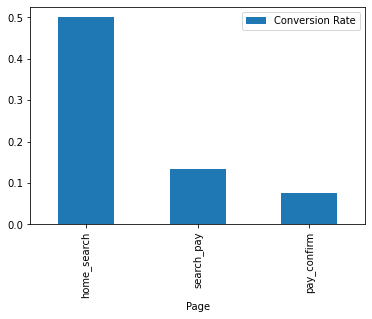

In [173]:
pd.DataFrame({"Page":cols, "Conversion Rate":vals}).set_index("Page").plot(kind = 'bar');

#### by Category Conversion

In [169]:
def conversion(cat):
    #denominator
    df1 = merge_df.groupby(cat).agg({"page_home":'count',"page_search":'count',"page_pay":'count'}).reset_index()
    df1.rename(columns = {"page_home":"home_search","page_search":"search_pay","page_pay":"pay_confirm"},
               inplace = True)
    df1.set_index(cat,inplace = True)
    #numerator
    df2 = merge_df.groupby(cat).agg({"page_search":'count',"page_pay":'count',"page_confirm":'count'}).reset_index()
    df2.rename(columns = {"page_search":"home_search","page_pay":"search_pay","page_confirm":"pay_confirm"},
               inplace = True)
    df2.set_index(cat,inplace = True)
    return df2/df1

In [170]:
device_cov = conversion("device")
device_cov

,home_search,search_pay,pay_confirm
device,,,
Desktop,0.5,0.1,0.05
Mobile,0.5,0.2,0.10


In [171]:
sex_cov = conversion("sex")
sex_cov

,home_search,search_pay,pay_confirm
sex,,,
Female,0.5,0.14,0.08
Male,0.5,0.13,0.07


For both device and sex, home page to search page conversion is constant. For both search page to pay page and pay page to confirmation page converion, mobile device seems to have advantage over desktop device, and female seems to have a slightly higher conversion rate than male. 

#### Fully Converted Users by Month Distribution

In [196]:
cov_df = merge_df[~merge_df['page_confirm'].isnull()]

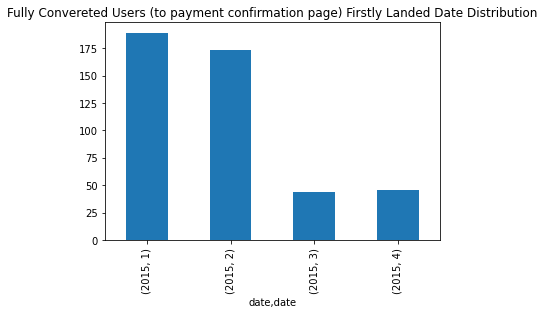

In [210]:
cov_df['date'].groupby([cov_df["date"].dt.year, cov_df["date"].dt.month]).count().plot(kind="bar");
plt.title("Fully Convereted Users (to payment confirmation page) Firstly Landed Date Distribution");

The date is when the user firstly landed on the site, and fully converted means users who first landed on home page got to the final payment confirmation page. According to the graph above, the earlier users landed, it is more likely they will be fully converted.